In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage
import noise
import random
import heapq
from matplotlib.animation import FuncAnimation
from pythreejs import *

In [15]:
plt.rcParams["figure.figsize"] = (150, 150)

In [16]:
# Terrain generation parameters
width = 1000
height = 1000
scale = 0.089
octaves = 9
persistence = 0.4

# Intialize an empty 2D array to store terrain data
terrain = np.zeros((height, width))


In [17]:
# Generate terrain with Perlin noise
for y in range(height):
    for x in range(width):
        value = noise.pnoise2(x * scale, y * scale, octaves=octaves, persistence=persistence)
        terrain[y][x] = value

# realistic terrain
terrain = (terrain + 1) / 2
terrain = terrain ** 2
terrain = terrain * 900 + 100
filter_size = 50
terrain = scipy.ndimage.gaussian_filter(terrain, filter_size)

# Ensure start and end points are well within the grid (not near edges)
margin = 50
start = (random.randint(margin, width - margin - 1), random.randint(margin, height - margin - 1))
end = (random.randint(margin, width - margin - 1), random.randint(margin, height - margin - 1))
intermediary_one = (random.randint(margin, width - margin - 1), random.randint(margin, height - margin - 1))
intermediary_two = (random.randint(margin, width - margin - 1), random.randint(margin, height - margin - 1))



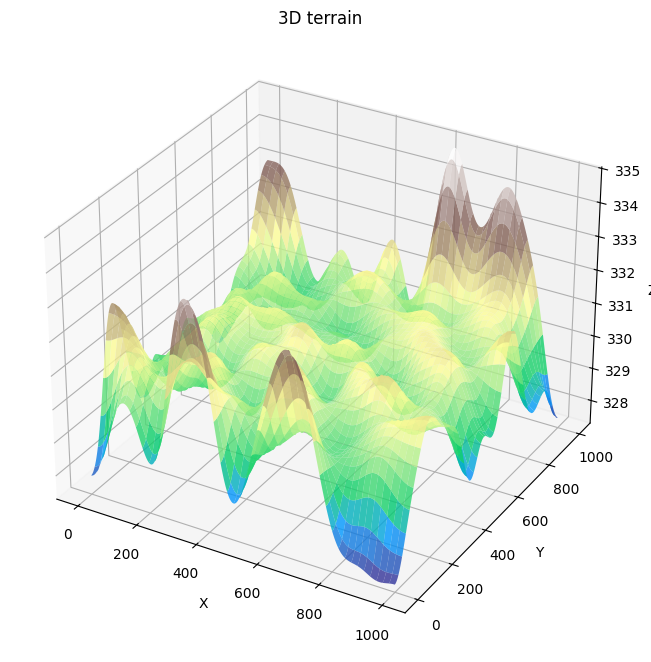

In [18]:
# 3D visualization
x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D terrain')
terrain_plot = ax.plot_surface(x_coords, y_coords, terrain, cmap='terrain', alpha=0.8)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

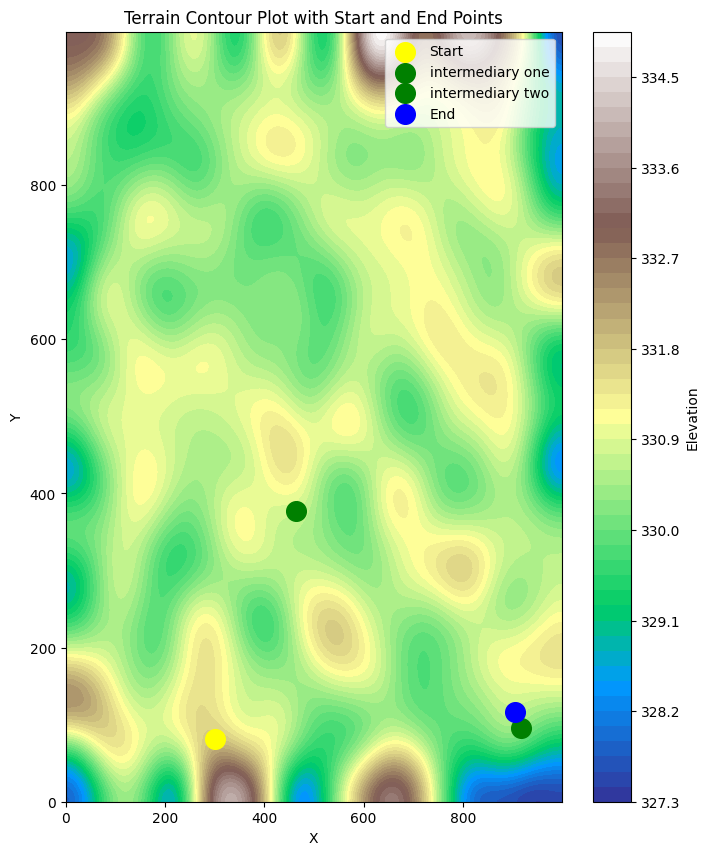

In [19]:
# 2D contour plot of terrain with start and end points
plt.figure(figsize=(8, 10))
contour = plt.contourf(terrain, cmap='terrain', levels=50)
plt.colorbar(contour, label='Elevation')
plt.scatter(start[0], start[1], color='yellow', s=200, label='Start', marker='o')
plt.scatter(intermediary_one[0], intermediary_one[1], color='green', s=200, label='intermediary one', marker='o')
plt.scatter(intermediary_two[0], intermediary_two[1], color='green', s=200, label='intermediary two', marker='o')
plt.scatter(end[0], end[1], color='blue', s=200, label='End', marker='o')
plt.legend()
plt.title('Terrain Contour Plot with Start and End Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [20]:
# A* pathfinding with 8-direction movement
def astar_8dir(terrain, start, end):
    height, width = terrain.shape
    neighbors = [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]

    def heuristic(a, b):
        return ((a[0]-b[0])**2 + (a[1]-b[1])**2)**0.5

    open_set = []
    heapq.heappush(open_set, (heuristic(start, end), 0, start, [start]))
    visited = set()

    while open_set:
        f, g, current, path = heapq.heappop(open_set)
        if current == end:
            return path
        if current in visited:
            continue
        visited.add(current)
        x, y = current
        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if 0 <= nx < width and 0 <= ny < height:
                neighbor = (nx, ny)
                if neighbor in visited:
                    continue
                # Cost to move: terrain elevation difference + movement cost
                move_cost = abs(terrain[ny, nx] - terrain[y, x]) + 1
                heapq.heappush(open_set, (
                    g + move_cost + heuristic(neighbor, end),
                    g + move_cost,
                    neighbor,
                    path + [neighbor]
                ))
    return None

# Modular pathfinding through waypoints
waypoints = [start, intermediary_one, intermediary_two,end]  # Add intermediary waypoints as needed
full_path = []
for i in range(len(waypoints) - 1):
    segment = astar_8dir(terrain, waypoints[i], waypoints[i+1])
    if segment is None:
        print(f"No path found between {waypoints[i]} and {waypoints[i+1]}")
        continue
    if i > 0:
        segment = segment[1:]  # Avoid duplicate points
    full_path.extend(segment)

print("Full path length:", len(full_path))


Full path length: 1515


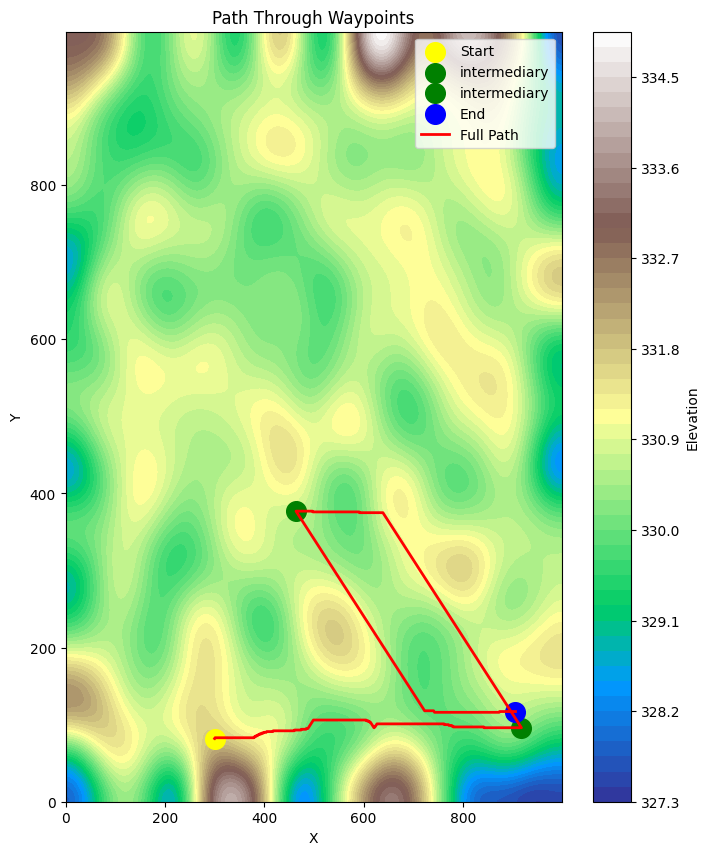

In [21]:
# Plot full path
if full_path:
    path_x, path_y = zip(*full_path)
    plt.figure(figsize=(8, 10))
    contour = plt.contourf(terrain, cmap='terrain', levels=50)
    plt.colorbar(contour, label='Elevation')
    plt.scatter(start[0], start[1], color='yellow', s=200, label='Start', marker='o')
    plt.scatter(intermediary_one[0], intermediary_one[1], color='green', s=200, label='intermediary', marker='o')
    plt.scatter(intermediary_two[0], intermediary_two[1], color='green', s=200, label='intermediary', marker='o')
    plt.scatter(end[0], end[1], color='blue', s=200, label='End', marker='o')
    plt.plot(path_x, path_y, color='red', linewidth=2, label='Full Path')
    plt.legend()
    plt.title('Path Through Waypoints')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
else:
    print("No segments found")

/var/folders/zg/_j5hfs9d12d155g0l1sy26n00000gn/T/ipykernel_83134/1334780732.py:4: UserWarning: The following kwargs were not used by contour: 'level'
  contour = ax.contour(terrain, cmap='terrain', level=50)


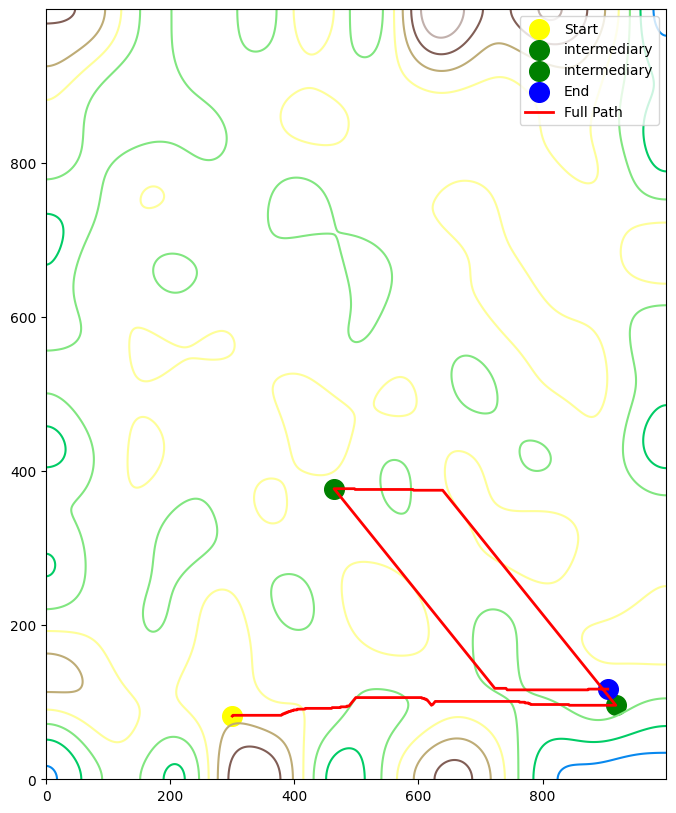

In [22]:
# Animated pathfinding plot

fig, ax = plt.subplots(figsize=(8, 10))
contour = ax.contour(terrain, cmap='terrain', level=50)
ax.scatter(start[0], start[1], color='yellow', s=200, label='Start', marker='o')
ax.scatter(intermediary_one[0], intermediary_one[1], color='green', s=200, label='intermediary', marker='o')
ax.scatter(intermediary_two[0], intermediary_two[1], color='green', s=200, label='intermediary', marker='o')
ax.scatter(end[0], end[1], color='blue', s=200, label='End', marker='o')
line, = ax.plot([], [], color='red', linewidth=2, label='Full Path')
ax.legend()

def update(frame):
    line.set_data(path_x[:frame], path_y[:frame])
    return line,

anim = FuncAnimation(fig, update, frames=len(full_path), interval=10, blit=True)
anim.save('anim_path.mp4')
plt.show()

In [23]:
terrain_small = terrain[::5,::5] # may be adjusted as performance allows

# Create grid
height, width = terrain_small.shape
x = np.arange(width)
y = np.arange(height)
xx, yy = np.meshgrid(x, y)
zz = terrain_small * 7


# Flatten arrays
vertices = np.column_stack((xx.flatten(), yy.flatten(), zz.flatten()))
zz_flat = zz.flatten()
faces = []

# Normalize heights
zz_norm = (zz_flat - zz_flat.min()) / (zz_flat.max() - zz_flat.min())

# RGB from terrain
colors_rgba = plt.cm.terrain(zz_norm)
colors_rgb = colors_rgba[:, :3]


### Marker plotting ###
# Scale and get x, y, z
start_small = (start[0] // 5, start[1] // 5)
start_x, start_y = start_small
start_z = zz[start_y, start_x]

end_small = (end[0] // 5, end[1] // 5)
end_x, end_y = end_small
end_z = zz[end_y,end_x]

intermediary_one_small = (intermediary_one[0] // 5, intermediary_one[1] // 5)
intermediary_one_x, intermediary_one_y = intermediary_one_small
intermediary_one_z = zz[intermediary_one_y, intermediary_one_x]

intermediary_two_small = (intermediary_two[0] // 5, intermediary_two[1] // 5)
intermediary_two_x, intermediary_two_y = intermediary_two_small
intermediary_two_z = zz[intermediary_two_y, intermediary_two_x]

# Build meshes for points
start_marker = Mesh(
    SphereGeometry(radius=5, widthSegments=16, heightSegments=16),
    MeshLambertMaterial(color='yellow'),
    position=[start_x, start_y, start_z + 10]
)

end_marker = Mesh(
    SphereGeometry(radius=5, widthSegments=16, heightSegments=16),
    MeshLambertMaterial(color='green'),
    position=[end_x, end_y, end_z + 10]
)

intermediary_one_marker = Mesh(
    SphereGeometry(radius=5, widthSegments=16, heightSegments=16),
    MeshLambertMaterial(color='blue'),
    position=[intermediary_one_x, intermediary_one_y, intermediary_one_z + 10]
)

intermediary_two_marker = Mesh(
    SphereGeometry(radius=5, widthSegments=16, heightSegments=16),
    MeshLambertMaterial(color='blue'),
    position=[intermediary_two_x, intermediary_two_y, intermediary_two_z + 10]
)


In [24]:
### A* pathfinding plotting ###
# Line scaling
path_points = []
for x, y in full_path:
    x_small = x // 5
    y_small = y // 5

    if 0 <= x_small < width and 0 <= y_small < height:
        z = zz[y_small, x_small]
        path_points.append([x_small, y_small, z + 5])

if path_points:
    path_array = np.array(path_points, dtype=np.float32)
    path_line = Line(
        geometry=BufferGeometry(attributes={
            'position': BufferAttribute(path_array, normalized=False)
        }),
        material=LineBasicMaterial(color='red', linewidth=5)
    )
else:
    path_line = None

In [25]:
# Build map 
# Build faces for mesh
for i in range(height - 1):
    for j in range(width - 1):
        idx = i * width + j
        faces.append([idx, idx + 1, idx + width])
        faces.append([idx + 1, idx + width + 1, idx + width])

geomtry = BufferGeometry(
    attributes={
        'position': BufferAttribute(vertices, normalized=False),
        'index': BufferAttribute(np.array(faces, dtype=np.uint32).flatten(), normalized=False),
        'color': BufferAttribute(colors_rgb, normalized=False)
    }
)

material = MeshLambertMaterial(vertexColors='VertexColors', side='DoubleSide')
mesh = Mesh(geomtry, material)

scene = Scene(children=[
    mesh,
    start_marker,
    end_marker,
    intermediary_one_marker,
    intermediary_two_marker,
    path_line,
    AmbientLight(color='#ffffff'),
    DirectionalLight(color='#ffffff', position=[0, 0, 10])
])



/Users/myles/Desktop/perlin_noise_proj/.venv/lib/python3.13/site-packages/pythreejs/traits.py:257: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


In [26]:
center_x = width // 2
center_y = height // 2
camera = PerspectiveCamera(position=[center_x, center_y, float(np.max(zz_flat)) * 3])
camera.lookAt([center_x, center_y, 0])
controls = OrbitControls(controlling=camera, target=[center_x, center_y, 0])
renderer = Renderer(camera=camera, scene=scene, controls=[controls], width=985, height=600)

renderer

Renderer(camera=PerspectiveCamera(position=(100.0, 100.0, 7032.331659133346), projectionMatrix=(1.0, 0.0, 0.0,…